In [6]:
'''
In this notebook, I'm demonstrating how the calculation of the hlms is consistent between the JAX implementation and the GWSurrogate implementation,
after the dynamics are appropriately swapped since the JAX calculation has more accuracy during the integration presently

'''

from jaxNRSur.SurrogateModel import NRSur7dq4Model
import jax.numpy as jnp
import numpy as np
import jax
from scipy.interpolate import interp1d
import equinox as eqx
from jaxNRSur.PolyPredictor import evaluate_ensemble_dynamics_at_index

import matplotlib.pyplot as plt
from jaxtyping import Array, Float, Int

q = 2
incl = 1.4376
phiref = 2.65

chi1 = jnp.array([0.0, 0, 0.7])
chi2 = jnp.array([0.0, 0.7, 0.0])

params = jnp.array([q, chi1[0], chi1[1], chi1[2], chi2[0], chi2[1], chi2[2]])

model = NRSur7dq4Model()
waveform_jax, dyn_jax = model.get_waveform(jnp.linspace(0, 1, 10), params) # note the time array here doesn't do anything 

import gwsurrogate

gwsurrogate.catalog.pull('NRSur7dq4')
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

t, h, dyn = sur(q, chi1, chi2, f_low=0, units='dimensionless', precessing_opts={'return_dynamics': True})

Try loading file from cache
Cache found and loading data

NRSur7dq4.h5 file exits, moving to /home/codespace/.python/current/lib/python3.10/site-packages/gwsurrogate/surrogate_downloads/backup/2025Feb19_19h:52m:56s_NRSur7dq4.h5.
There are a lot of backup files in /home/codespace/.python/current/lib/python3.10/site-packages/gwsurrogate/surrogate_downloads/backup, consider removing some.
Loaded NRSur7dq4 model


In [7]:
orbphase_gwsur = interp1d(t, dyn['orbphase'][:,], bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb)
quat_gwsur = interp1d(t, dyn['q_copr'][:,], bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb)
chi1_gwsur = interp1d(t, dyn['chiA_copr'][:,].T, bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb)
chi2_gwsur = interp1d(t, dyn['chiB_copr'][:,].T, bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb)

In [8]:
Omega_interp_gwsur = jnp.hstack([quat_gwsur.T, orbphase_gwsur[:,jnp.newaxis], chi1_gwsur.T, chi2_gwsur.T])

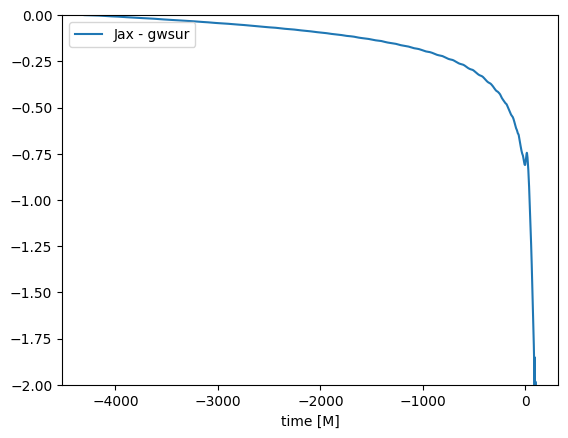

In [9]:
plt.plot(model.data.t_coorb, dyn_jax[:,4]-orbphase_gwsur, label='Jax - gwsur')

plt.xlabel('time [M]')
plt.legend(loc='upper left')

plt.ylim(-2,0)

plt.show()

In [ ]:
# In this section of code we compute the hlm waveforms in the inertial frame (involving the rotation via the wigner d matrix)
import jax
from gwtools.harmonics import sYlm as _sYlm

coorb_params = jax.vmap(model._get_coorb_params, in_axes=(None, 0))(q, Omega_interp_gwsur)

# Get the lambda parameters to go into the waveform calculation
lambdas = jax.vmap(model._get_fit_params)(
    jax.vmap(model._get_coorb_params, in_axes=(None, 0))(q, Omega_interp_gwsur)
)

# TODO need to work out how to vmap this later
inertial_h_lms = jnp.zeros((len(model.data.t_coorb), model.n_modes_extended), dtype=complex)

inertial_h_lm_array = {}
coorb_h_lm_array = {}


for mode in model.modelist_dict.keys():
    # get the coorb hlms
    coorb_h_lm_plus, coorb_h_lm_minus = model.get_coorb_hlm(lambdas, mode=mode)

    coorb_h_lm_array[mode] = coorb_h_lm_plus
    if mode[1] > 0:
        coorb_h_lm_array[(mode[0], -mode[1])] = coorb_h_lm_minus
    
    # Multiply copressing mode by Wigner-D components (N_modes x times)
    # Note that this also does the rotation of the quaternions into the inertial frame

    inertial_h_lms += (model.wigner_d_coefficients(Omega_interp_gwsur[:,:4], Omega_interp_gwsur[:,4], mode).T * coorb_h_lm_plus).T
    inertial_h_lms += (model.wigner_d_coefficients(Omega_interp_gwsur[:,:4], Omega_interp_gwsur[:,4], (mode[0], -mode[1])).T * coorb_h_lm_minus).T

# Sum along the N_modes axis with the spherical harmonics to generate strain as function of time
inertial_h = jnp.zeros(len(model.data.t_coorb), dtype=complex)
for idx in model.modelist_dict_extended.values():

    mode = list(model.modelist_dict_extended.keys())[idx]
    inertial_h += model.harmonics[idx](incl, jnp.pi/2 - phiref) * inertial_h_lms[:,idx]

    inertial_h_lm_array[list(model.modelist_dict_extended.keys())[idx]] = inertial_h_lms[:,idx]

0 (2, 0)


/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


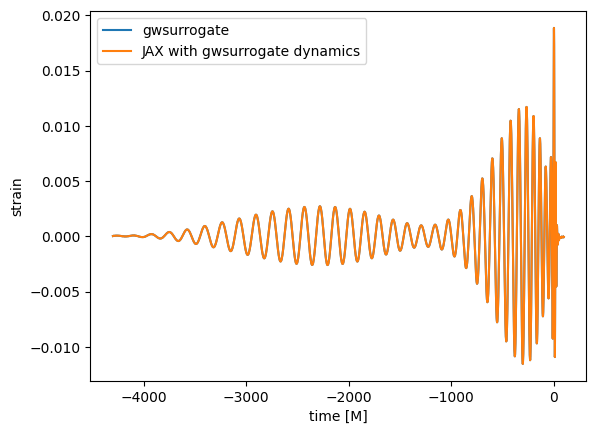

1 (2, 1)


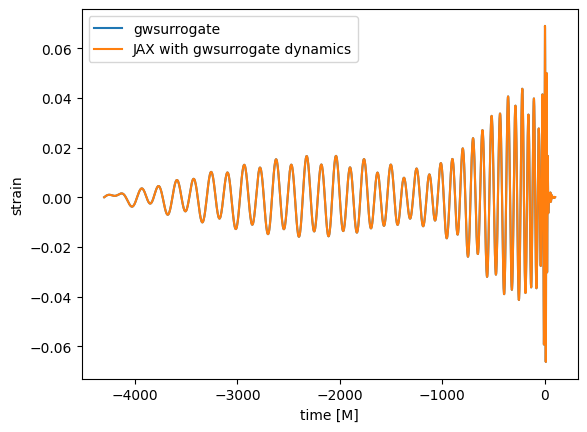

2 (2, -1)


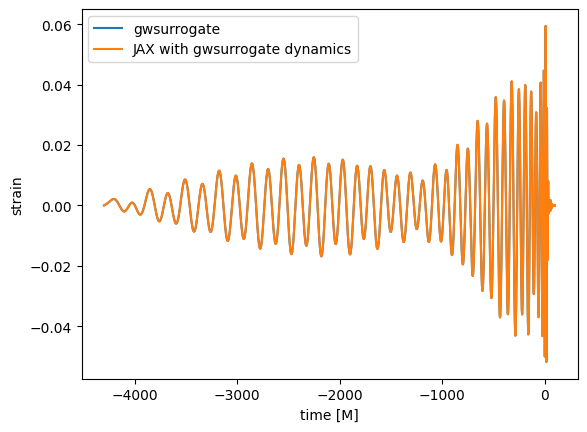

3 (2, 2)


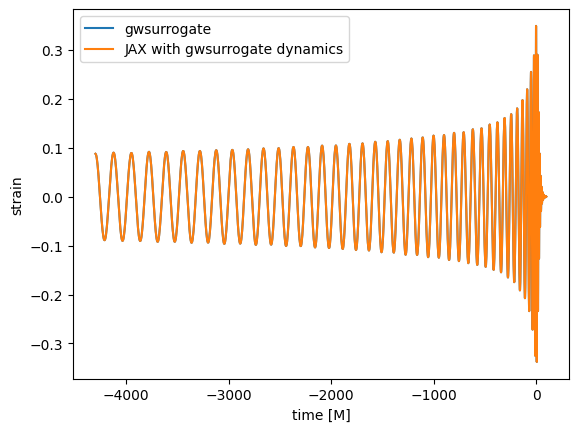

4 (2, -2)


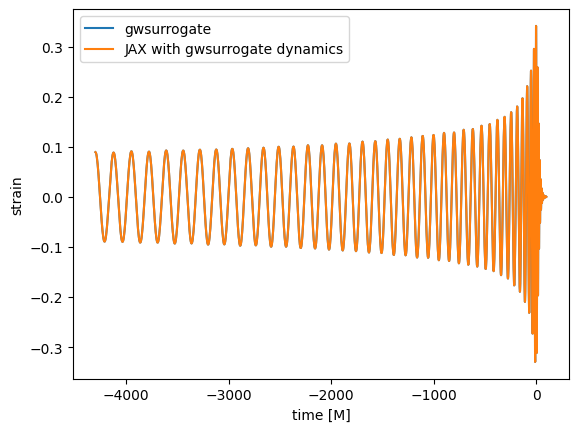

5 (3, 0)


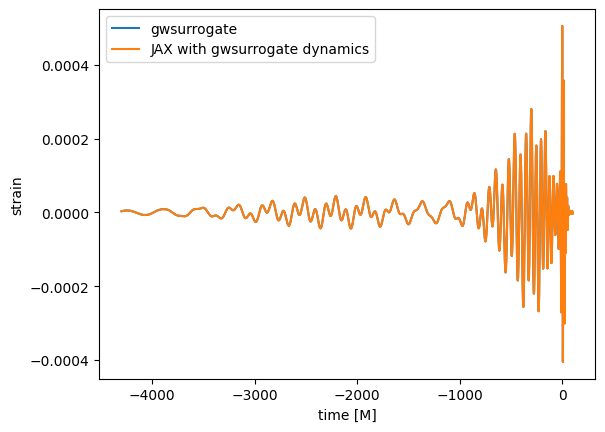

6 (3, 1)


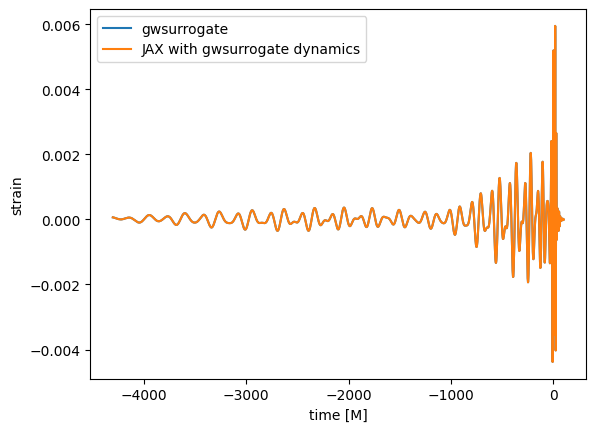

7 (3, -1)


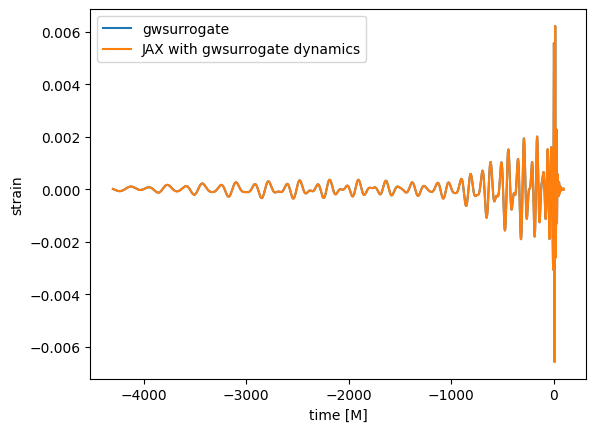

8 (3, 2)


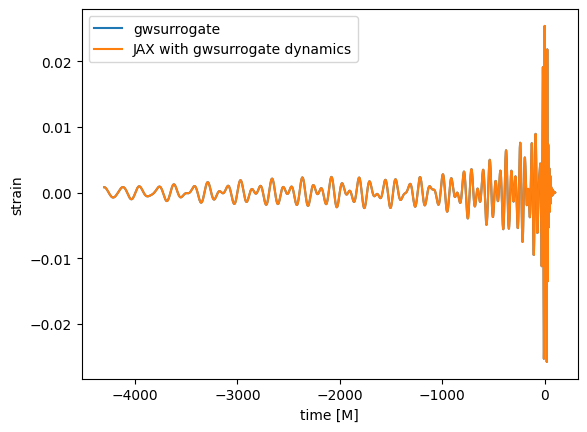

9 (3, -2)


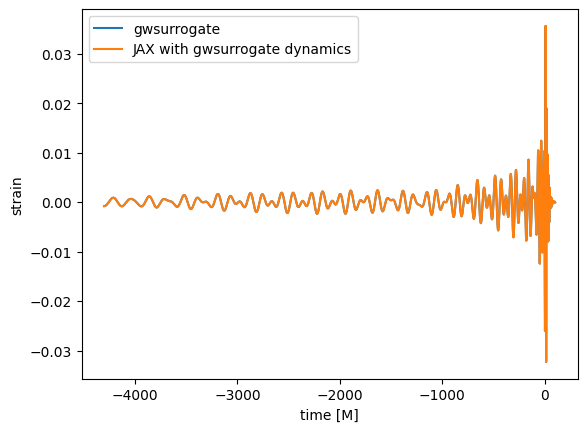

10 (3, 3)


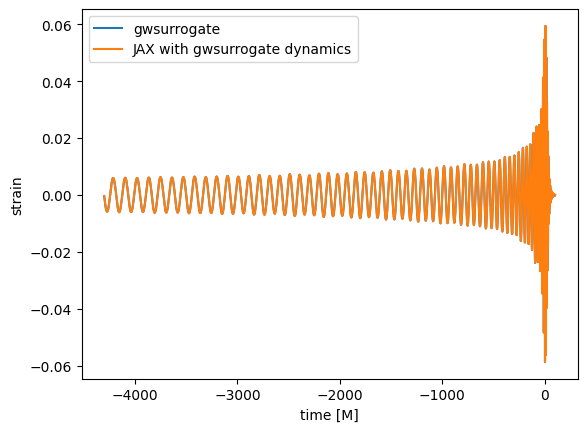

11 (3, -3)


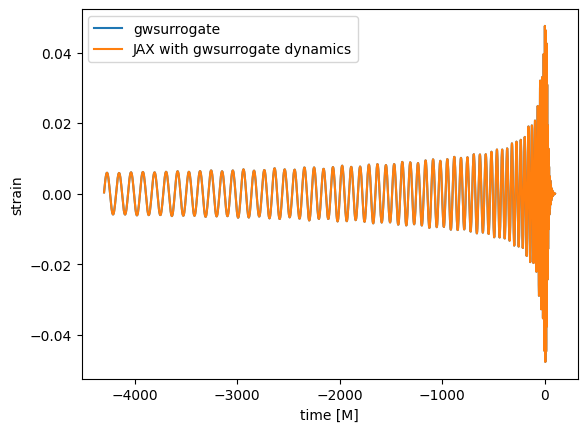

<Figure size 640x480 with 0 Axes>

In [13]:
# Plotting a comparison between the modes
for mode, i in model.modelist_dict_extended.items():
    if mode[0] < 4:
        print(i, mode)

        plt.plot(model.data.t_coorb, interp1d(t,h[mode], bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb), label='gwsurrogate')
        plt.plot(model.data.t_coorb, inertial_h_lm_array[mode], label='JAX with gwsurrogate dynamics')
        plt.legend()
        plt.xlabel('time [M]')
        plt.ylabel('strain')
        #plt.xlim(-200, 50)
        plt.show()
        plt.clf()

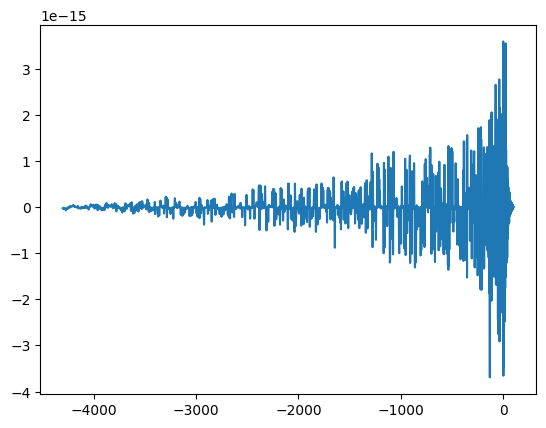

In [ ]:
# Computing and plotting the difference in the full (mode summed) inertial frame waveform. Note that this is within numerical error (due to the slightly different interpolation)
t, h_full, dyn = sur(q, chi1, chi2, f_low=0, inclination=incl, phi_ref=phiref, units='dimensionless', precessing_opts={'return_dynamics': True})

plt.plot(model.data.t_coorb, interp1d(t, h_full, bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb) - inertial_h)

In [16]:
idx

20